In [1]:
import pandas as pd

import numpy as np 
np.random.seed(42)

import re

import geocoder
import geopy.distance

import math 

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.io as pio 
import plotly.express as px
%matplotlib inline

from tqdm.notebook import tqdm
tqdm.pandas()

from IPython.core.display import display, HTML 

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics 
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestRegressor 
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from textblob import TextBlob

from collections import Counter

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = None

In [2]:
# Настройка цветовой гаммы 
sns.set_style('darkgrid',
              {'axes.facecolor': '0.8',
               'grid.color': 'white',
               'figure.facecolor': '0.95'})
clrmap = ["#9b59b6", "#95a5a6", "#e74c3c", "#34495e","#3498db", "#2ecc71"]
sns.set_palette(clrmap)

In [3]:
# Установка формата статического изображения
png_renderer = pio.renderers['png']
png_renderer.width = 1200
png_renderer.height = 700
png_renderer.engine = 'kaleido'
pio.renderers.default = 'png'  

In [4]:
hotels = pd.read_csv('hotels.csv')

display(HTML("""<a href="https://drive.google.com/file/d/1WWv9ARJ7icmt5Gq7XTogqvq95-7jQb_7/view?usp=sharing">Исходный dataframe hotels.csv"""))

FileNotFoundError: [Errno 2] No such file or directory: 'hotels.csv'

In [ ]:
hotels.head(3)

# Исследование данных, анализ признаков

In [5]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
#признаки с пропусками
null_percent = hotels.isnull().mean() * 100
cols_with_null = null_percent[null_percent>0].sort_values(ascending=False)
display(cols_with_null)

lng    0.63288
lat    0.63288
dtype: float64

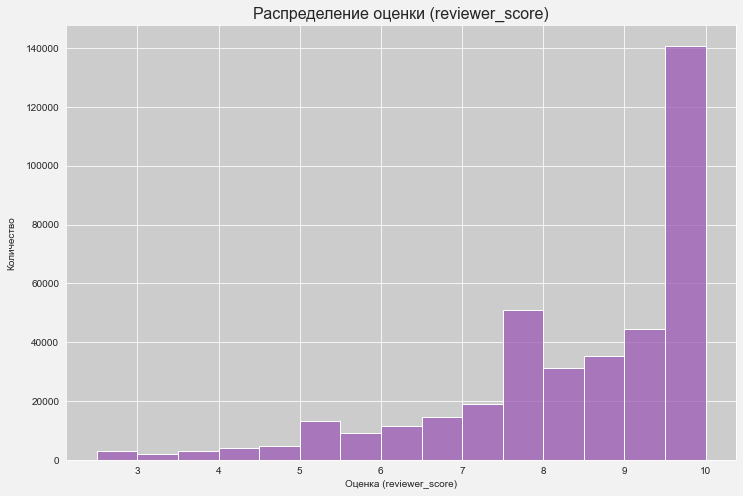

In [7]:
# посмотрим распределение целвеого признака
fig = plt.figure(figsize = (12, 8))

histplot = sns.histplot(
    data = hotels,
    x = 'reviewer_score',
    bins = 15,
    );
histplot.set_title('Распределение оценки (reviewer_score)', fontsize = 16);
histplot.set_xlabel('Оценка (reviewer_score)');
histplot.set_ylabel('Количество');
histplot.yaxis.set_label_coords(-0.075, 0.5)

plt.show()

Люди предпочитают ставить хорошие отзывы. Характер роста - экспонециальный. 

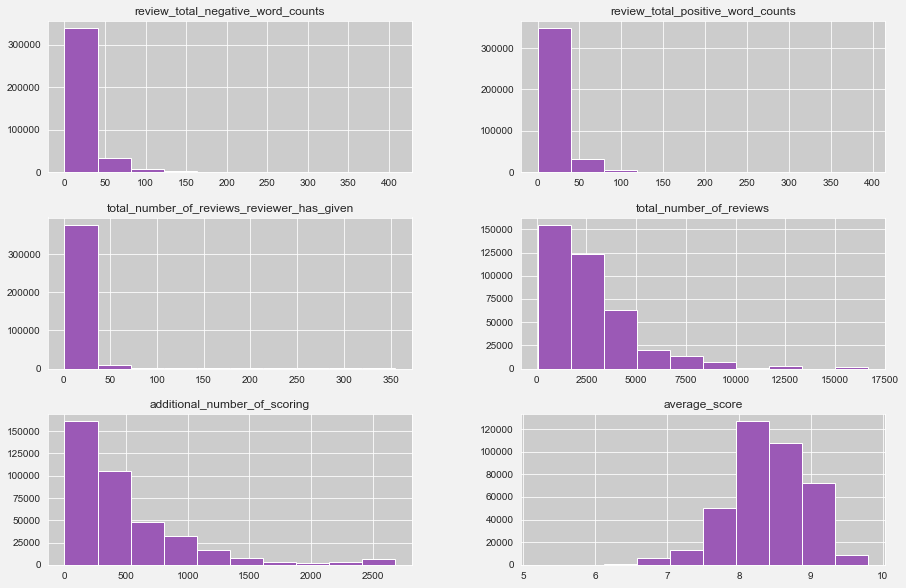

In [8]:
# посмотрим имеющихся числовых признаков
hotels[['review_total_negative_word_counts', 
        'review_total_positive_word_counts',
        'total_number_of_reviews_reviewer_has_given', 
        'total_number_of_reviews', 
        'additional_number_of_scoring', 
        'average_score']
      ].hist(figsize=(15, 10))
pass

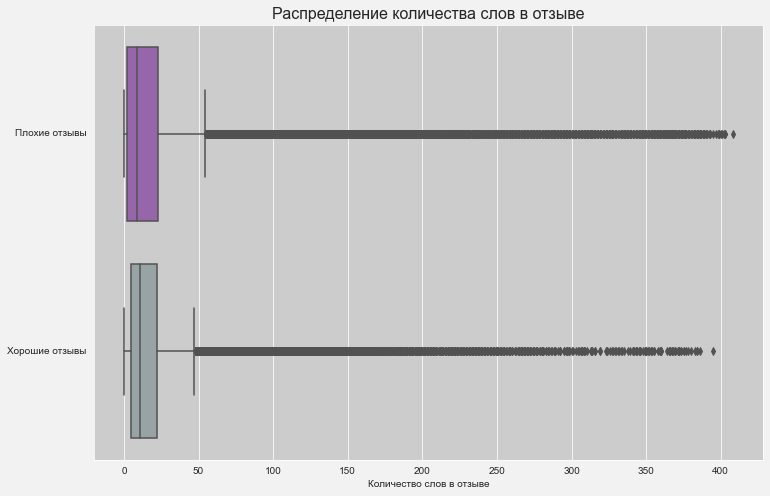

In [9]:
# посмотрим подробнее распрделение количества слов в отзыве
rev_len = hotels[['review_total_negative_word_counts', 'review_total_positive_word_counts']]

fig = plt.figure(figsize = (12, 8));
boxplot = sns.boxplot(data = rev_len, orient = 'h');
boxplot.set_yticklabels(('Плохие отзывы', 'Хорошие отзывы'), va = 'center');
boxplot.set_title('Распределение количества слов в отзыве', fontsize = 16);
boxplot.set_xlabel('Количество слов в отзыве');
plt.show() 

Два самых важных признака (кроме содержания отзыва) - длина отзыва. Их точно придется обрабатывать (нормализовать/стандартизировать/логарифмировать), распределение ассиметричное. 

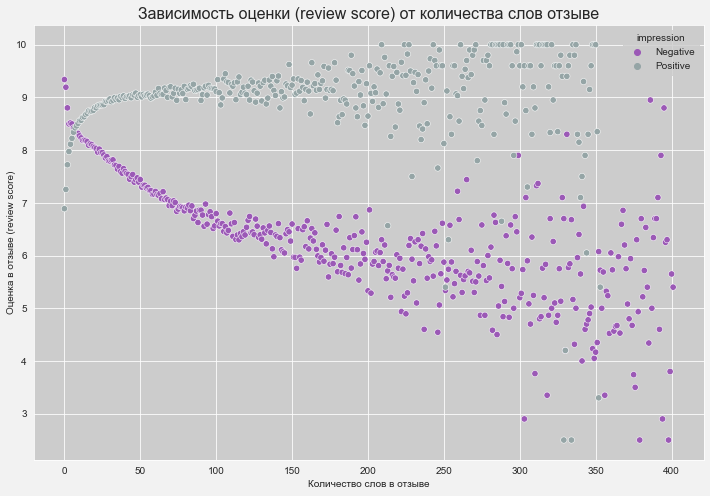

In [10]:
#посмотрим зависимость целевого признака от количества слов в отзыве
neg_rev_score_dist = hotels[['review_total_negative_word_counts', 'reviewer_score']].groupby('review_total_negative_word_counts', as_index = False)['reviewer_score'].agg('mean')
neg_rev_score_dist.rename(columns={'review_total_negative_word_counts':'total_word_counts'}, inplace=True)
neg_rev_score_dist['impression']='Negative'
pos_rev_score_dist = hotels[['review_total_positive_word_counts', 'reviewer_score']].groupby('review_total_positive_word_counts', as_index = False)['reviewer_score'].agg('mean')
pos_rev_score_dist.rename(columns={'review_total_positive_word_counts':'total_word_counts'}, inplace=True)
pos_rev_score_dist['impression']='Positive'
rev_score_dist = pd.concat([neg_rev_score_dist, pos_rev_score_dist])
rev_score_dist['total_word_counts'] = rev_score_dist.index

fig = plt.figure(figsize = (12, 8));
scatterplot = sns.scatterplot(data = rev_score_dist, 
                              x = 'total_word_counts', 
                              y = 'reviewer_score', 
                              s = 40,
                              hue = 'impression',
                             );
scatterplot.set_ylabel('Оценка в отзыве (review score)', va = 'center');
scatterplot.set_title('Зависимость оценки (review score) от количества слов отзыве', fontsize = 16);
scatterplot.set_xlabel('Количество слов в отзыве');
plt.show() 

Ожидаемо более длинный негативный отзыв соотвествует более низким оценкам, аналогичная ситуация с положительными отзывами. Распредление напоминает экспонециальное. До значений признака в 50 слов зависимость более строгая, затем размывается, появляются выбросы.

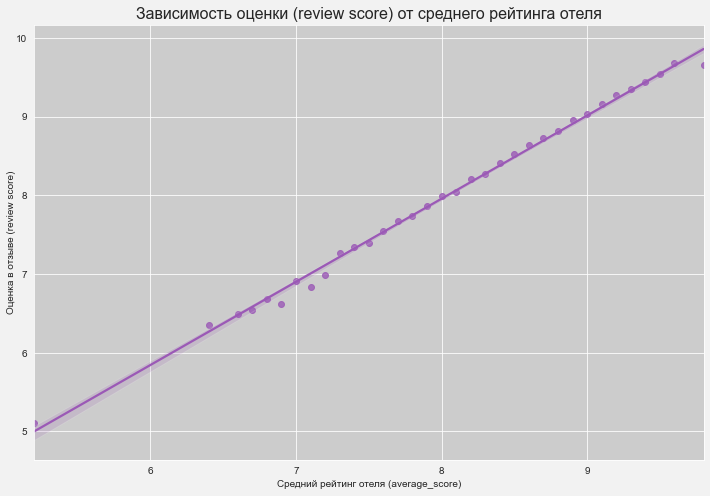

In [11]:
#посмотрим зависимость целевого признака от среднего рейтинга отеля
aver_score_dist = hotels[['average_score', 'reviewer_score']].groupby('average_score', as_index = False)['reviewer_score'].agg('mean')

fig = plt.figure(figsize = (12, 8));
regplot = sns.regplot(data = aver_score_dist, 
                              x = 'average_score', 
                              y = 'reviewer_score', 
                             );
regplot.set_ylabel('Оценка в отзыве (review score)', va = 'center');
regplot.set_title('Зависимость оценки (review score) от среднего рейтинга отеля', fontsize = 16);
regplot.set_xlabel('Средний рейтинг отеля (average_score)');
plt.show() 

Прямопропорциональная зависимость, этот признак должен будет иметь существенный вес при обучении модели. 

# Удаление дубликатов, заполнение пропусков, обработка текста

In [ ]:
# предварительная обработка текста. Выполнение этих функций заняло в сумме более 4 часов, поэтому после первого выполнения сохранил hotels с двумя новыми признаками (очищенные отзывы)
def review_cleaning(review):
    review = re.sub('[^a-zA-Z]', ' ', review) 
    review = review.lower()
    review = review.split() 
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))] 
    review = ' '.join(review)  
    return review

hotels['new_positive_review'] = hotels['positive_review'].progress_apply(review_cleaning)
hotels['new_negative_review'] = hotels['negative_review'].progress_apply(review_cleaning)

hotels.to_csv('df_train_.csv', index=False)

In [95]:
hotels = pd.read_csv('df_train_.csv') 
display(HTML("""<a href="https://drive.google.com/file/d/1BxF8-L1v1811Mm7MiD_firoumzO29aMy/view?usp=sharing">Обработанный dataframe hotels.csv"""))

In [13]:
#заполним пропуски в обработанных признаках
hotels['new_positive_review']=hotels['new_positive_review'].fillna('')
hotels['new_negative_review']=hotels['new_negative_review'].fillna('')

In [14]:
#определение и удаление дубликатов
mask = hotels.duplicated(subset = hotels.columns)
data_duplicates = hotels[mask]
print(f'Число найденных и удаленных дубликатов: {data_duplicates.shape[0]}')

hotels = hotels.drop_duplicates(subset = hotels.columns)

Число найденных и удаленных дубликатов: 307


In [15]:
#получаем список отелей с пропуском географической широты
fill_lat = hotels.groupby(['hotel_address'], as_index = False)['lat'].median()
fill_lat.rename(columns={'lat':'fill_lat'}, inplace=True)
null_lat=fill_lat[fill_lat.isna().any(axis=1)]

# заполняем пропуски с помощью geocoder
null_lat['fill_lat']=null_lat['hotel_address'].apply(lambda x: geocoder.opencage(x,  key='924f41fc864d4bed8c9b438bff7c67e1',timeout=None ).json['lat'])
hotels = hotels.merge(null_lat, on=['hotel_address'], how = 'left') # вовзращаем значения в hotels
hotels['lat']=hotels['lat'].fillna(hotels['fill_lat'])
null_lat

,hotel_address,fill_lat
279,20 Rue De La Ga t 14th arr 75014 Paris France,32.7673
331,23 Rue Damr mont 18th arr 75018 Paris France,48.8925
516,4 rue de la P pini re 8th arr 75008 Paris France,33.2074
839,Bail n 4 6 Eixample 08010 Barcelona Spain,41.3888
956,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,48.2333
986,Hasenauerstra e 12 19 D bling 1190 Vienna Austria,48.2068
1021,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,48.2167
1022,Josefst dter Stra e 22 08 Josefstadt 1080 Vien...,48.2167
1052,Landstra er G rtel 5 03 Landstra e 1030 Vienna...,48.1981
1136,Paragonstra e 1 11 Simmering 1110 Vienna Austria,48.2068


In [16]:
# аналогично для долготы
fill_lng = hotels.groupby(['hotel_address'], as_index = False)['lng'].median()
fill_lng.rename(columns={'lng':'fill_lng'}, inplace=True)
null_lng=fill_lng[fill_lng.isna().any(axis=1)] 
null_lng['fill_lng']=null_lng['hotel_address'].apply(lambda x: geocoder.opencage(x,  key='924f41fc864d4bed8c9b438bff7c67e1', timeout=None).json['lng'])
hotels = hotels.merge(null_lng, on=['hotel_address'], how = 'left')
hotels['lng']=hotels['lng'].fillna(hotels['fill_lng'])
null_lng

,hotel_address,fill_lng
279,20 Rue De La Ga t 14th arr 75014 Paris France,-96.7776
331,23 Rue Damr mont 18th arr 75018 Paris France,2.3444
516,4 rue de la P pini re 8th arr 75008 Paris France,-97.1163
839,Bail n 4 6 Eixample 08010 Barcelona Spain,2.1590
956,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,16.3500
986,Hasenauerstra e 12 19 D bling 1190 Vienna Austria,16.2646
1021,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,16.3500
1022,Josefst dter Stra e 22 08 Josefstadt 1080 Vien...,16.3500
1052,Landstra er G rtel 5 03 Landstra e 1030 Vienna...,16.3948
1136,Paragonstra e 1 11 Simmering 1110 Vienna Austria,16.2646


# Создание новых признаков

**Разбор отзывов на слова и выделение топ встречающихся по позитивным и негативным отзывам**

In [17]:
#создаем признаки со списками слов после очистки в отзывах
hotels['pos_words']=hotels['new_positive_review'].apply(lambda x: x.split())
hotels['neg_words']=hotels['new_negative_review'].apply(lambda x: x.split())

In [18]:
# создаем общие списки негативных и позитивных слов
neg_word_list = []
for x in hotels['neg_words']: 
    neg_word_list.extend(x)
array = neg_word_list
neg_counter = Counter(array)
neg_top = neg_counter.most_common(200)
most_neg_words= [word for word, word_count in neg_top]
neg_words = set(most_neg_words)

pos_word_list = []
for x in hotels['pos_words']: 
    pos_word_list.extend(x)

array = pos_word_list
pos_counter = Counter(array)
pos_top = pos_counter.most_common(200)
most_pos_words= [word for word, word_count in pos_top]
pos_words = set(most_pos_words)

#создаем уникальные списки слов (без встречающихся и среди негативных и среди позитивных)
true_neg = neg_words - pos_words
true_pos = pos_words - neg_words

In [19]:
list(true_neg)[:10] #пример 10 слов

['wait',
 'told',
 'hot',
 'late',
 'car',
 'cost',
 'light',
 'smell',
 'think',
 'find']

In [20]:
list(true_pos)[:10] #пример 10 слов

['quiet',
 'transport',
 'return',
 'new',
 'attract',
 'near',
 'loung',
 'valu',
 'effici',
 'choic']

In [21]:
#счетчик количества позитивных слов в обоих типах отзывах
def num_pos_words(col):
    count = 0
    for word in col:
        if word in true_pos:
            count += 1
    return count

hotels['pos_words_in_pos_rev'] = hotels['pos_words'].apply(num_pos_words)
hotels['pos_words_in_neg_rev'] = hotels['neg_words'].apply(num_pos_words)

#счетчик количества негативных слов в обоих типах отзывах
def num_neg_words(col):
    count = 0
    for word in col:
        if word in true_neg:
            count += 1
    return count

hotels['neg_words_in_neg_rev'] = hotels['neg_words'].apply(num_neg_words)
hotels['neg_words_in_pos_rev'] = hotels['pos_words'].apply(num_neg_words)

In [22]:
# отношение количества позитивных или негативных слов к общему количеству слов в отзыве
hotels['pos_word_per_pos_rev'] = hotels['pos_words_in_pos_rev']/hotels['review_total_positive_word_counts']
hotels['neg_word_per_pos_rev'] = hotels['neg_words_in_pos_rev']/hotels['review_total_positive_word_counts']
hotels['pos_word_per_neg_rev'] = hotels['pos_words_in_neg_rev']/hotels['review_total_negative_word_counts']
hotels['neg_word_per_neg_rev'] = hotels['neg_words_in_neg_rev']/hotels['review_total_negative_word_counts']

hotels['pos_word_per_pos_rev'] = hotels['pos_word_per_pos_rev'].fillna(0)
hotels['neg_word_per_pos_rev'] = hotels['neg_word_per_pos_rev'].fillna(0)
hotels['pos_word_per_neg_rev'] = hotels['pos_word_per_neg_rev'].fillna(0)
hotels['neg_word_per_neg_rev'] = hotels['neg_word_per_neg_rev'].fillna(0)

hotels['pos_word_per_pos_rev'] = hotels['pos_word_per_pos_rev'].apply(lambda x: 0 if x == float("inf") else x )
hotels['neg_word_per_pos_rev'] = hotels['neg_word_per_pos_rev'].apply(lambda x: 0 if x == float("inf") else x )
hotels['pos_word_per_neg_rev'] = hotels['pos_word_per_neg_rev'].apply(lambda x: 0 if x == float("inf") else x )
hotels['neg_word_per_neg_rev'] = hotels['neg_word_per_neg_rev'].apply(lambda x: 0 if x == float("inf") else x )

In [23]:
#длина очищенных отзывов
hotels['clean_pos_len']=hotels['pos_words'].apply(lambda x: len(x))
hotels['clean_neg_len']=hotels['neg_words'].apply(lambda x: len(x))

**Анализ тональности с помощью TextBlob**

In [24]:
# анализ позитивного отзыва
hotels_arr_pos = hotels['positive_review'].to_numpy()
polarity_arr=[]
subjectivity_arr=[]

for a in hotels_arr_pos:
    text=a
    testimonial = TextBlob(text)
    testimonial.sentiment
    polarity_arr.append(testimonial.sentiment.polarity)
    subjectivity_arr.append(testimonial.sentiment.subjectivity)
    
hotels['pos_review_polarity']=polarity_arr
hotels['pos_review_subjectivity']=subjectivity_arr

In [25]:
# анализ негативного отзыва
hotels_arr_neg = hotels['negative_review'].to_numpy()
polarity_arr=[]
subjectivity_arr=[]

for a in hotels_arr_neg:
    text=a
    testimonial = TextBlob(text)
    testimonial.sentiment
    polarity_arr.append(testimonial.sentiment.polarity)
    subjectivity_arr.append(testimonial.sentiment.subjectivity)
    
hotels['neg_review_polarity'] = polarity_arr
hotels['neg_review_subjectivity'] = subjectivity_arr

**Анализ тональности с помощью Vader**

In [26]:
analyz = SentimentIntensityAnalyzer()

hotels['negative_review_analyze'] = hotels['negative_review'].apply(lambda x: analyz.polarity_scores(x))
hotels['positive_review_analyze'] = hotels['positive_review'].apply(lambda x: analyz.polarity_scores(x))

hotels.loc[:,['neg_rev_neg_mood_score', 'neg_rev_neutral_mood_score','neg_rev_pos_mood_score','neg_rev_mood_score']] = list(hotels['negative_review_analyze'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
hotels.loc[:,['pos_rev_neg_mood_score', 'pos_rev_neutral_mood_score','pos_rev_pos_mood_score','pos_rev_mood_score']] = list(hotels['positive_review_analyze'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)

**Извлечение признаков из даты отзыва**

In [27]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['year'] = hotels['review_date'].dt.year
hotels['month'] = hotels['review_date'].dt.month
hotels['dayofweek'] = hotels['review_date'].dt.dayofweek
hotels['weekend'] = hotels['dayofweek'].apply(lambda x: 0 if x < 5 else 1)

**Извлечение признаков из адреса отеля**

In [28]:
# название города
def city_from_adress(col):
    res = col.split(' ')[-2]
    if res == 'United':
        res = col.split(' ')[-5]
    return res
hotels['hotel_city'] = hotels['hotel_address'].apply(city_from_adress)
city_list = hotels['hotel_city'].unique()

In [29]:
# координаты центра
city_lat = []
city_lng = []

for i in city_list:
    lat = geocoder.opencage(i,  key='924f41fc864d4bed8c9b438bff7c67e1',timeout=None ).json['lat']
    city_lat.append(lat)
    lng = geocoder.opencage(i,  key='924f41fc864d4bed8c9b438bff7c67e1',timeout=None ).json['lng']
    city_lng.append(lng)
    
city_coords = pd.DataFrame(
    {'hotel_city': city_list,
    'city_lat': city_lat,
    'city_lng': city_lng
    })

hotels = hotels.merge(city_coords, on=['hotel_city'], how = 'left')
hotels ['coords'] = list(zip(hotels['lat'],hotels['lng'], hotels['city_lat'], hotels['city_lng']))

city_coords

,hotel_city,city_lat,city_lng
0,London,51.507322,-0.127647
1,Paris,48.858890,2.320041
2,Amsterdam,52.372760,4.893604
3,Milan,45.464194,9.189635
4,Vienna,48.208354,16.372504
5,Barcelona,41.382894,2.177432


In [30]:
# расстояние до центра используя geopy.distance
def distance(col):
    coords_1 = col[:2]
    coords_2 = col[-2:]
    return geopy.distance.geodesic(coords_1, coords_2).m

hotels['distance_from_center'] = hotels ['coords'].apply(distance)

In [31]:
hotels['distance_from_center'].describe()

count    3.864960e+05
mean     8.270912e+03
std      2.025524e+05
min      3.770763e+01
25%      1.350268e+03
50%      2.414442e+03
75%      3.944885e+03
max      7.949797e+06
Name: distance_from_center, dtype: float64

В этом признаке необходимо будет избавиться от аномалий (расстояние от центра города - 8000 км)

In [32]:
# название страны
def country_from_adress(col):
    res = col.split(' ')[-1]
    if res == 'Kingdom':
        res = 'United Kingdom'
    return res

hotels['hotel_country'] = hotels['hotel_address'].apply(country_from_adress)
hotels['hotel_country'].unique()

array(['United Kingdom', 'France', 'Netherlands', 'Italy', 'Austria',
       'Spain'], dtype=object)

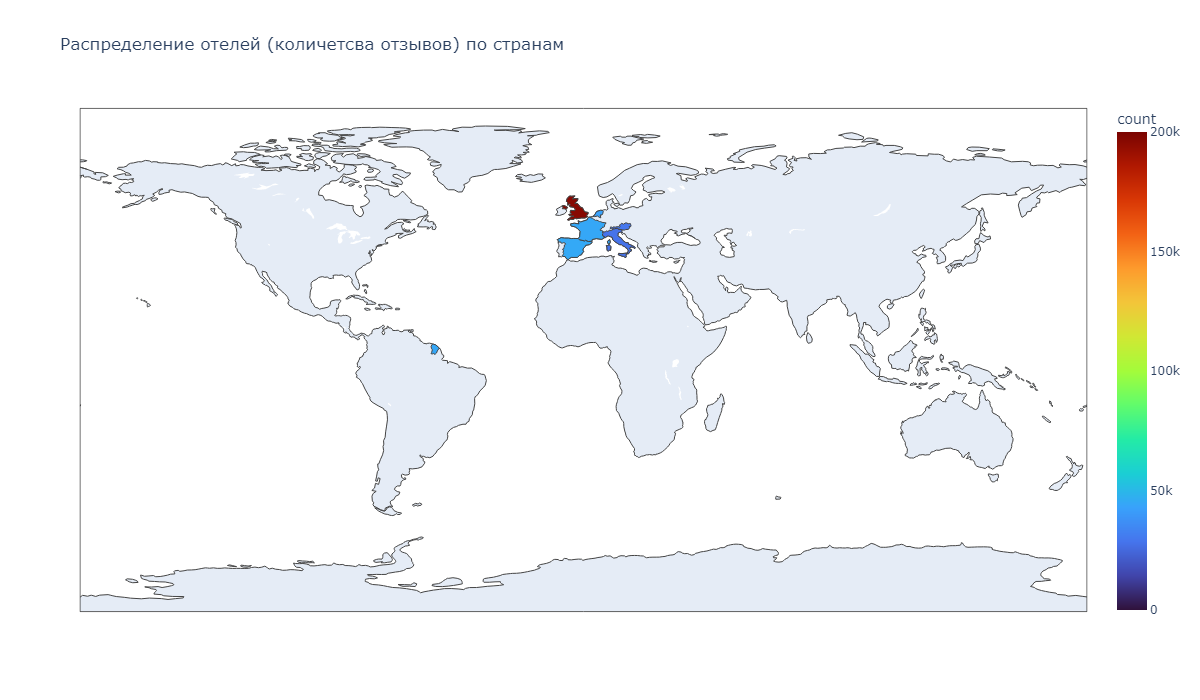

In [34]:
countries = hotels['hotel_country'].value_counts()
countries = pd.DataFrame({'country':countries.index, 'count':countries.values})

fig = px.choropleth(
    data_frame = countries, 
    locations = 'country', 
    locationmode = 'country names', 
    color = 'count',
    range_color = [0, 200000], 
    title = 'Распределение отелей (количества отзывов) по странам', 
    width = 800, 
    height = 500, 
    color_continuous_scale = 'Turbo'
    );

pio.write_html(fig, file = 'plotly//country distribution.html', auto_open = False)

display(HTML("""<a href="https://htmlpreview.github.io/?https://github.com/IgorAbalakin/HH_data_project/blob/main/plotly/age%20distribution.html">Интерактивная визуализация Plotly"""))

fig.show()

In [35]:
# отзыв резидента
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x.strip())
hotels['home_review'] = np.where((hotels['hotel_country'] == hotels['reviewer_nationality']), 1, 0)

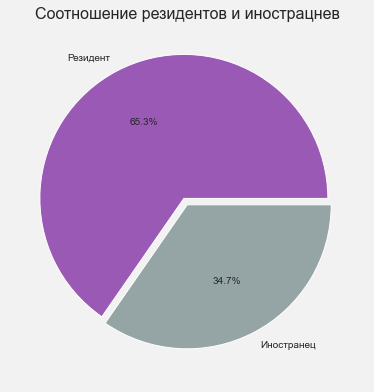

In [36]:
fig = plt.figure(figsize = (5, 5))

axes = fig.add_axes([0, 0, 1, 1])
axes.set_title('Соотношение резидентов и инострацнев', fontsize = 16)
axes.pie(
    hotels['home_review'].value_counts(),
    labels = ['Резидент', 'Иностранец'],
    autopct = '%.1f%%',
    explode = [0.05, 0]
    );

plt.show()

**Название отеля**

In [37]:
# топ 50
hotel_name_list = hotels['hotel_name'].value_counts(normalize=True).nlargest(50)
hotels['hotel_name'] = hotels['hotel_name'].apply(lambda x: x.strip() if x in hotel_name_list else 'other') 

(hotel_name_list.nlargest(10))*100

Britannia International Hotel Canary Wharf           0.928082
Strand Palace Hotel                                  0.829504
Park Plaza Westminster Bridge London                 0.800784
Copthorne Tara Hotel London Kensington               0.695479
DoubleTree by Hilton Hotel London Tower of London    0.615530
Grand Royale London Hyde Park                        0.573874
Holiday Inn London Kensington                        0.542567
Hilton London Metropole                              0.512813
Intercontinental London The O2                       0.501687
Millennium Gloucester Hotel London                   0.488750
Name: hotel_name, dtype: float64

**Национальность автора**

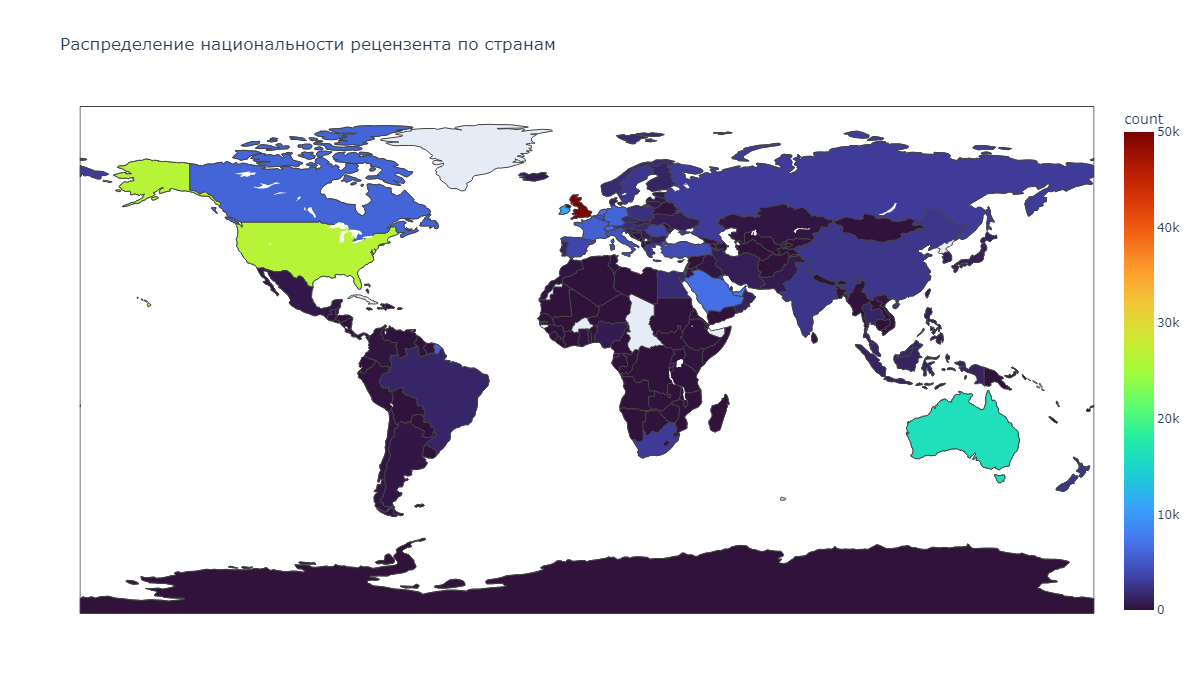

In [39]:
nationalities = hotels['reviewer_nationality'].value_counts()
nationalities = pd.DataFrame({'country':nationalities.index, 'count':nationalities.values})

fig = px.choropleth(
    data_frame = nationalities, 
    locations = 'country', 
    locationmode = 'country names', 
    color = 'count',
    range_color = [0, 50000], 
    title = 'Распределение национальности рецензента по странам', 
    width = 800, 
    height = 500, 
    color_continuous_scale = 'Turbo'
    );

pio.write_html(fig, file = 'plotly//nationality distribution.html', auto_open = False)

display(HTML("""<a href="https://htmlpreview.github.io/?https://github.com/IgorAbalakin/HH_data_project/blob/main/plotly/age%20distribution.html">Интерактивная визуализация Plotly"""))

fig.show()

In [40]:
# отсавляем топ 10 популярных
reviewer_nationality_list =(hotels['reviewer_nationality'].value_counts(normalize=True).nlargest(10))
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x if x in reviewer_nationality_list else 'other')

**Теги**

In [41]:
#представление тегов списком
def tags(col):
    res = []
    tag_split = col.split(',')
    for tag in tag_split:
        reg = re.compile('[^a-zA-Z0-9 ]')
        res.append(reg.sub('', tag).strip())
    return res

hotels['new_tags'] = hotels['tags'].apply(tags)

In [42]:
# продолжительность пребывания
def night_number(col):
    for tag in col:
        if tag.split(' ')[0] == 'Stayed':
            return int(tag.split(' ')[1])
        
hotels['night_number'] = hotels['new_tags'].apply(night_number)
hotels['night_number'] = hotels['night_number'].fillna(hotels['night_number'].median())

hotels['night_number'].describe()

count    386496.000000
mean          2.361103
std           1.646106
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          30.000000
Name: night_number, dtype: float64

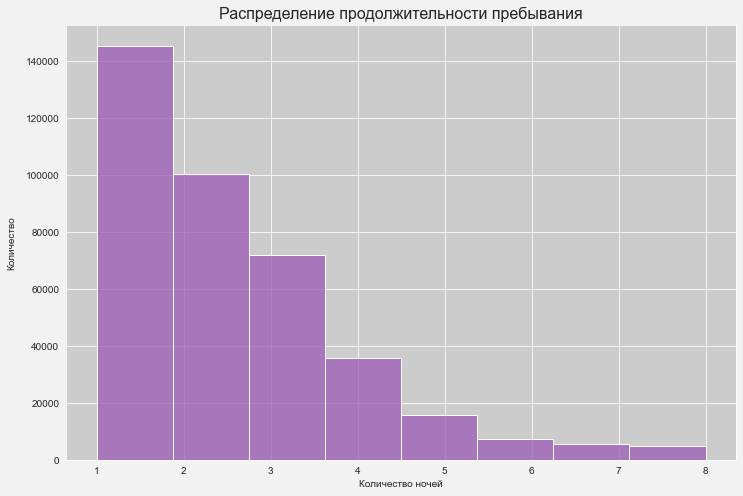

In [43]:
hotels['night_number'] = hotels['night_number'].apply(lambda x: x if x <= 7 else 8)

fig = plt.figure(figsize = (12, 8))

histplot = sns.histplot(
    data = hotels,
    x = 'night_number',
    bins = 8,
    );
histplot.set_title('Распределение продолжительности пребывания', fontsize = 16);
histplot.set_xlabel('Количество ночей');
histplot.set_ylabel('Количество');
histplot.yaxis.set_label_coords(-0.075, 0.5)

plt.show()

In [44]:
# теги описание поездки
conditions = ['Couple',
              'Solo traveler',
              'Business trip',
              'Family with young children',
              'Group',
              'Family with older children',
              'With a pet',
              'Leisure trip',
              'Submitted from a mobile device']

for name in conditions:
    hotels[name] =''

for col in hotels[conditions].columns:
    hotels[col]=hotels['new_tags'].apply(lambda x: 1 if col in x else 0)

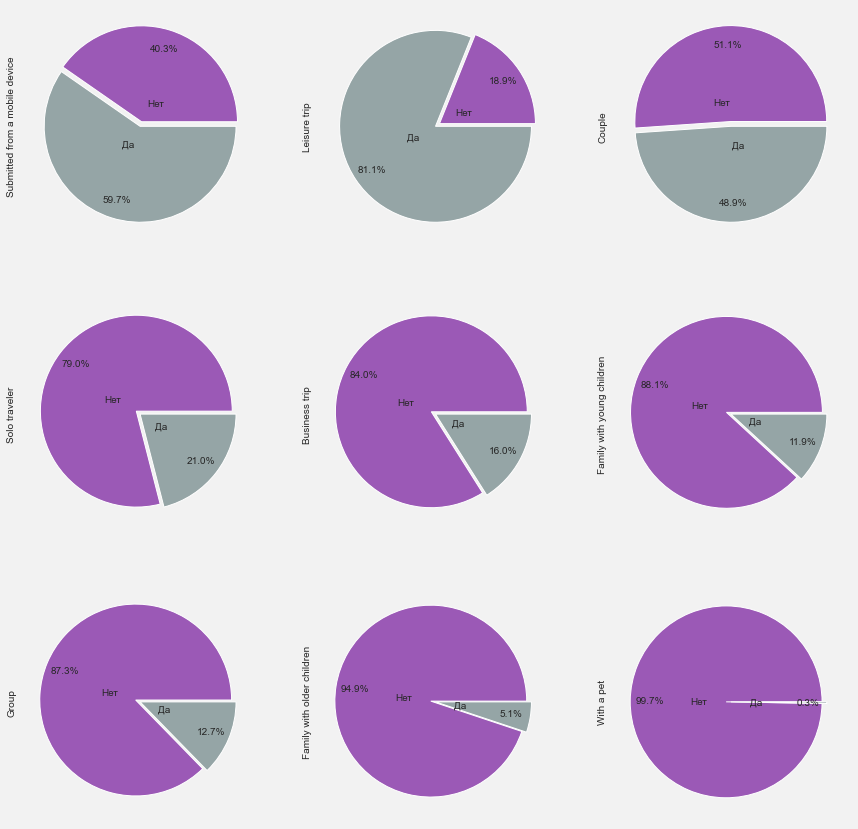

In [45]:
conditions_counts = pd.concat([
    hotels['Submitted from a mobile device'].value_counts(),
    hotels['Leisure trip'].value_counts(),
    hotels['Couple'].value_counts(),
    hotels['Solo traveler'].value_counts(),
    hotels['Business trip'].value_counts(),
    hotels['Family with young children'].value_counts(),
    hotels['Group'].value_counts(), 
    hotels['Family with older children'].value_counts(), 
    hotels['With a pet'].value_counts(),
    ], 
    axis=1)

conditions_counts.plot.pie(subplots=True, 
                           figsize=(15, 15), 
                           layout=(3, 3),
                           labels = ['Нет', 'Да'],
                           autopct = '%.1f%%',
                           explode = [0.05, 0],
                           labeldistance=0.2,
                           pctdistance=0.8,
                           legend=None)
pass

Вероятнее всего пара первых и пара последних признаков не окажут на модель никакого влияния.

In [46]:
# тип комнаты
def room_type(col):
    for tag in col:
        if tag.split(' ')[-1] == 'Room':
            return tag[:-4]
        
hotels['room_type'] = hotels['new_tags'].apply(room_type)

room_type =(hotels['room_type'].value_counts(normalize=True).nlargest(15))
hotels['room_type'] = hotels['room_type'].apply(lambda x: x.strip() if x in room_type else 'other')

room_type*100

Double                      8.740009
Standard Double             7.999364
Superior Double             7.790022
Deluxe Double               6.164976
Double or Twin              5.572725
Standard Double or Twin     4.325288
Classic Double              4.174906
Superior Double or Twin     3.391200
Standard Twin               2.426308
Single                      2.393184
Twin                        2.079503
Executive Double            1.577680
Classic Double or Twin      1.513420
Superior Twin               1.500502
Club Double                 1.485596
Name: room_type, dtype: float64

In [47]:
# количество тегов
hotels['tags_length'] = hotels['new_tags'].apply(lambda x: len(x))
hotels['tags_length'].value_counts()

5    223293
4    158448
3      4122
6       563
2        65
1         5
Name: tags_length, dtype: int64

**Возраст отзыва**

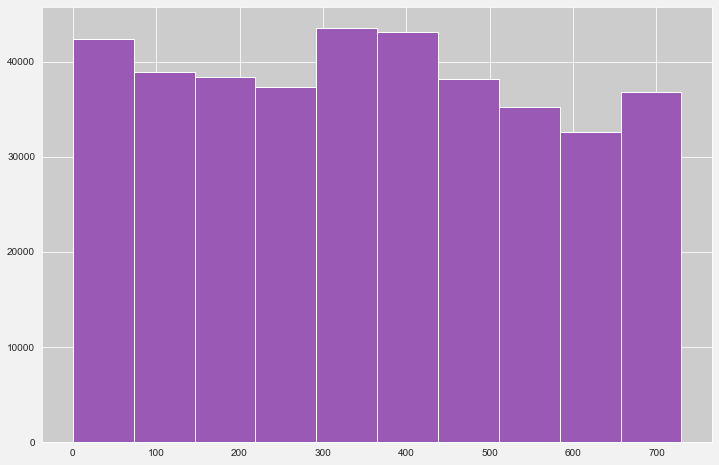

In [48]:
#выделяем количество дней
hotels['num_days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split(' ')[0]))
hotels['num_days_since_review'].hist(figsize=(12, 8))
pass

Признак распределен равномерно, и также не будет представлять интерес для модели. 

# Нормализация данных

In [49]:
# логарифмируем признаки
hotels['review_total_positive_word_counts'] = np.log(hotels['review_total_positive_word_counts']+ 1)

hotels['review_total_negative_word_counts'] = np.log(hotels['review_total_negative_word_counts']+ 1)

hotels['additional_number_of_scoring'] = np.log(hotels['additional_number_of_scoring'])

hotels['total_number_of_reviews_reviewer_has_given'] = np.log(hotels['total_number_of_reviews_reviewer_has_given'])

hotels['total_number_of_reviews'] = np.log(hotels['total_number_of_reviews'])

hotels['pos_words_in_pos_rev'] = np.log(hotels['pos_words_in_pos_rev']+1)
hotels['pos_words_in_neg_rev'] = np.log(hotels['pos_words_in_neg_rev']+1)

hotels['neg_words_in_neg_rev'] = np.log(hotels['neg_words_in_neg_rev']+1)
hotels['neg_words_in_pos_rev'] = np.log(hotels['neg_words_in_pos_rev']+1)

distance_anomal_mean = hotels[hotels['distance_from_center']<100000]['distance_from_center'].mean()
hotels['distance_from_center'] = hotels['distance_from_center'].apply(lambda x: x if x <= 100000 else distance_anomal_mean)
hotels['distance_from_center'] = np.log(hotels['distance_from_center'])

# Кодирование признаков

In [50]:
# Просто LabelEncoder
hotels['reviewer_nationality'] = LabelEncoder().fit_transform(hotels['reviewer_nationality'])
hotels['night_number'] = LabelEncoder().fit_transform(hotels['night_number'])
hotels['hotel_country'] = LabelEncoder().fit_transform(hotels['hotel_country'])
hotels['room_type'] = LabelEncoder().fit_transform(hotels['room_type'])
hotels['hotel_name'] = LabelEncoder().fit_transform(hotels['hotel_name'])

# Очистка данных

In [51]:
hotels = hotels.drop(['fill_lat',
                      'fill_lng',
                      'review_date',
                      'lat',
                      'lng',
                      'city_lat',
                      'city_lng'], axis=1)

In [52]:
hotels_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(hotels_columns, axis = 1, inplace=True)

In [53]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386496 entries, 0 to 386495
Data columns (total 51 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386496 non-null  float64
 1   average_score                               386496 non-null  float64
 2   hotel_name                                  386496 non-null  int32  
 3   reviewer_nationality                        386496 non-null  int32  
 4   review_total_negative_word_counts           386496 non-null  float64
 5   total_number_of_reviews                     386496 non-null  float64
 6   review_total_positive_word_counts           386496 non-null  float64
 7   total_number_of_reviews_reviewer_has_given  386496 non-null  float64
 8   reviewer_score                              386496 non-null  float64
 9   pos_words_in_pos_rev                        386496 non-null  float64
 

In [54]:
hotels.describe()

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,pos_words_in_pos_rev,pos_words_in_neg_rev,neg_words_in_neg_rev,neg_words_in_pos_rev,pos_word_per_pos_rev,neg_word_per_pos_rev,pos_word_per_neg_rev,neg_word_per_neg_rev,clean_pos_len,clean_neg_len,pos_review_polarity,pos_review_subjectivity,neg_review_polarity,neg_review_subjectivity,neg_rev_neg_mood_score,neg_rev_neutral_mood_score,neg_rev_pos_mood_score,neg_rev_mood_score,pos_rev_neg_mood_score,pos_rev_neutral_mood_score,pos_rev_pos_mood_score,pos_rev_mood_score,year,month,dayofweek,weekend,distance_from_center,hotel_country,home_review,night_number,Couple,Solo traveler,Business trip,Family with young children,Group,Family with older children,With a pet,Leisure trip,Submitted from a mobile device,room_type,tags_length,num_days_since_review
count,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,3.864960e+05,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000
mean,5.768829,8.397421,44.643502,7.780665,2.080050,7.590904,2.444327,1.285475,8.397299,0.866471,0.226716,0.746362,0.195552,0.105650,0.012781,0.016582,0.054718,9.608187,8.913758,0.372848,0.572063,3.400529e-02,0.400678,0.322517,0.619097,0.053004,-0.208878,0.034816,0.576306,0.388309,0.593480,2016.120889,6.488554,2.721971,0.263615,7.690205,3.605980,0.346503,1.337253,0.489128,0.210005,0.160245,0.118526,0.126928,0.051196,0.002704,0.810754,0.596663,11.072469,4.569610,354.339339
std,0.991200,0.547861,12.516292,2.526910,1.456008,0.852014,1.049116,1.126013,1.635747,0.656453,0.434298,0.617743,0.422393,0.103655,0.033796,0.041910,0.077900,11.139269,13.642004,0.297820,0.275630,2.406506e-01,0.249024,0.410245,0.392881,0.115826,0.453637,0.103355,0.273880,0.235555,0.342564,0.687683,3.351249,2.084593,0.440593,0.917772,1.731603,0.475856,1.511238,0.499882,0.407312,0.366833,0.323231,0.332892,0.220397,0.051928,0.391705,0.490568,4.894870,0.520157,208.958145
min,0.000000,5.200000,0.000000,0.000000,0.000000,3.761200,0.000000,0.000000,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,-0.998100,0.000000,0.000000,0.000000,-0.983200,2015.000000,1.000000,0.000000,0.000000,3.629863,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,5.129899,8.100000,50.000000,8.000000,1.098612,7.057037,1.791759,0.000000,7.500000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,0.137500,0.496667,-5.000000e-02,0.300000,0.000000,0.000000,0.000000,-0.709600,0.000000,0.408000,0.229000,0.358425,2016.000000,4.000000,1.000000,0.000000,7.208058,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,8.000000,4.000000,175.000000
50%,5.834811,8.400000,50.000000,8.000000,2.302585,7.665753,2.484907,1.098612,8.800000,0.693147,0.000000,0.693147,0.000000,0.090909,0.000000,0.000000,0.000000,6.000000,4.000000,0.400000,0.601190,3.832913e-17,0.400000,0.107000,0.781000,0.000000,-0.177900,0.000000,0.588000,0.404000,0.708900,2016.000000,7.000000,2.000000,0.000000,7.789224,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000

# Анализ мультиколлинеарности

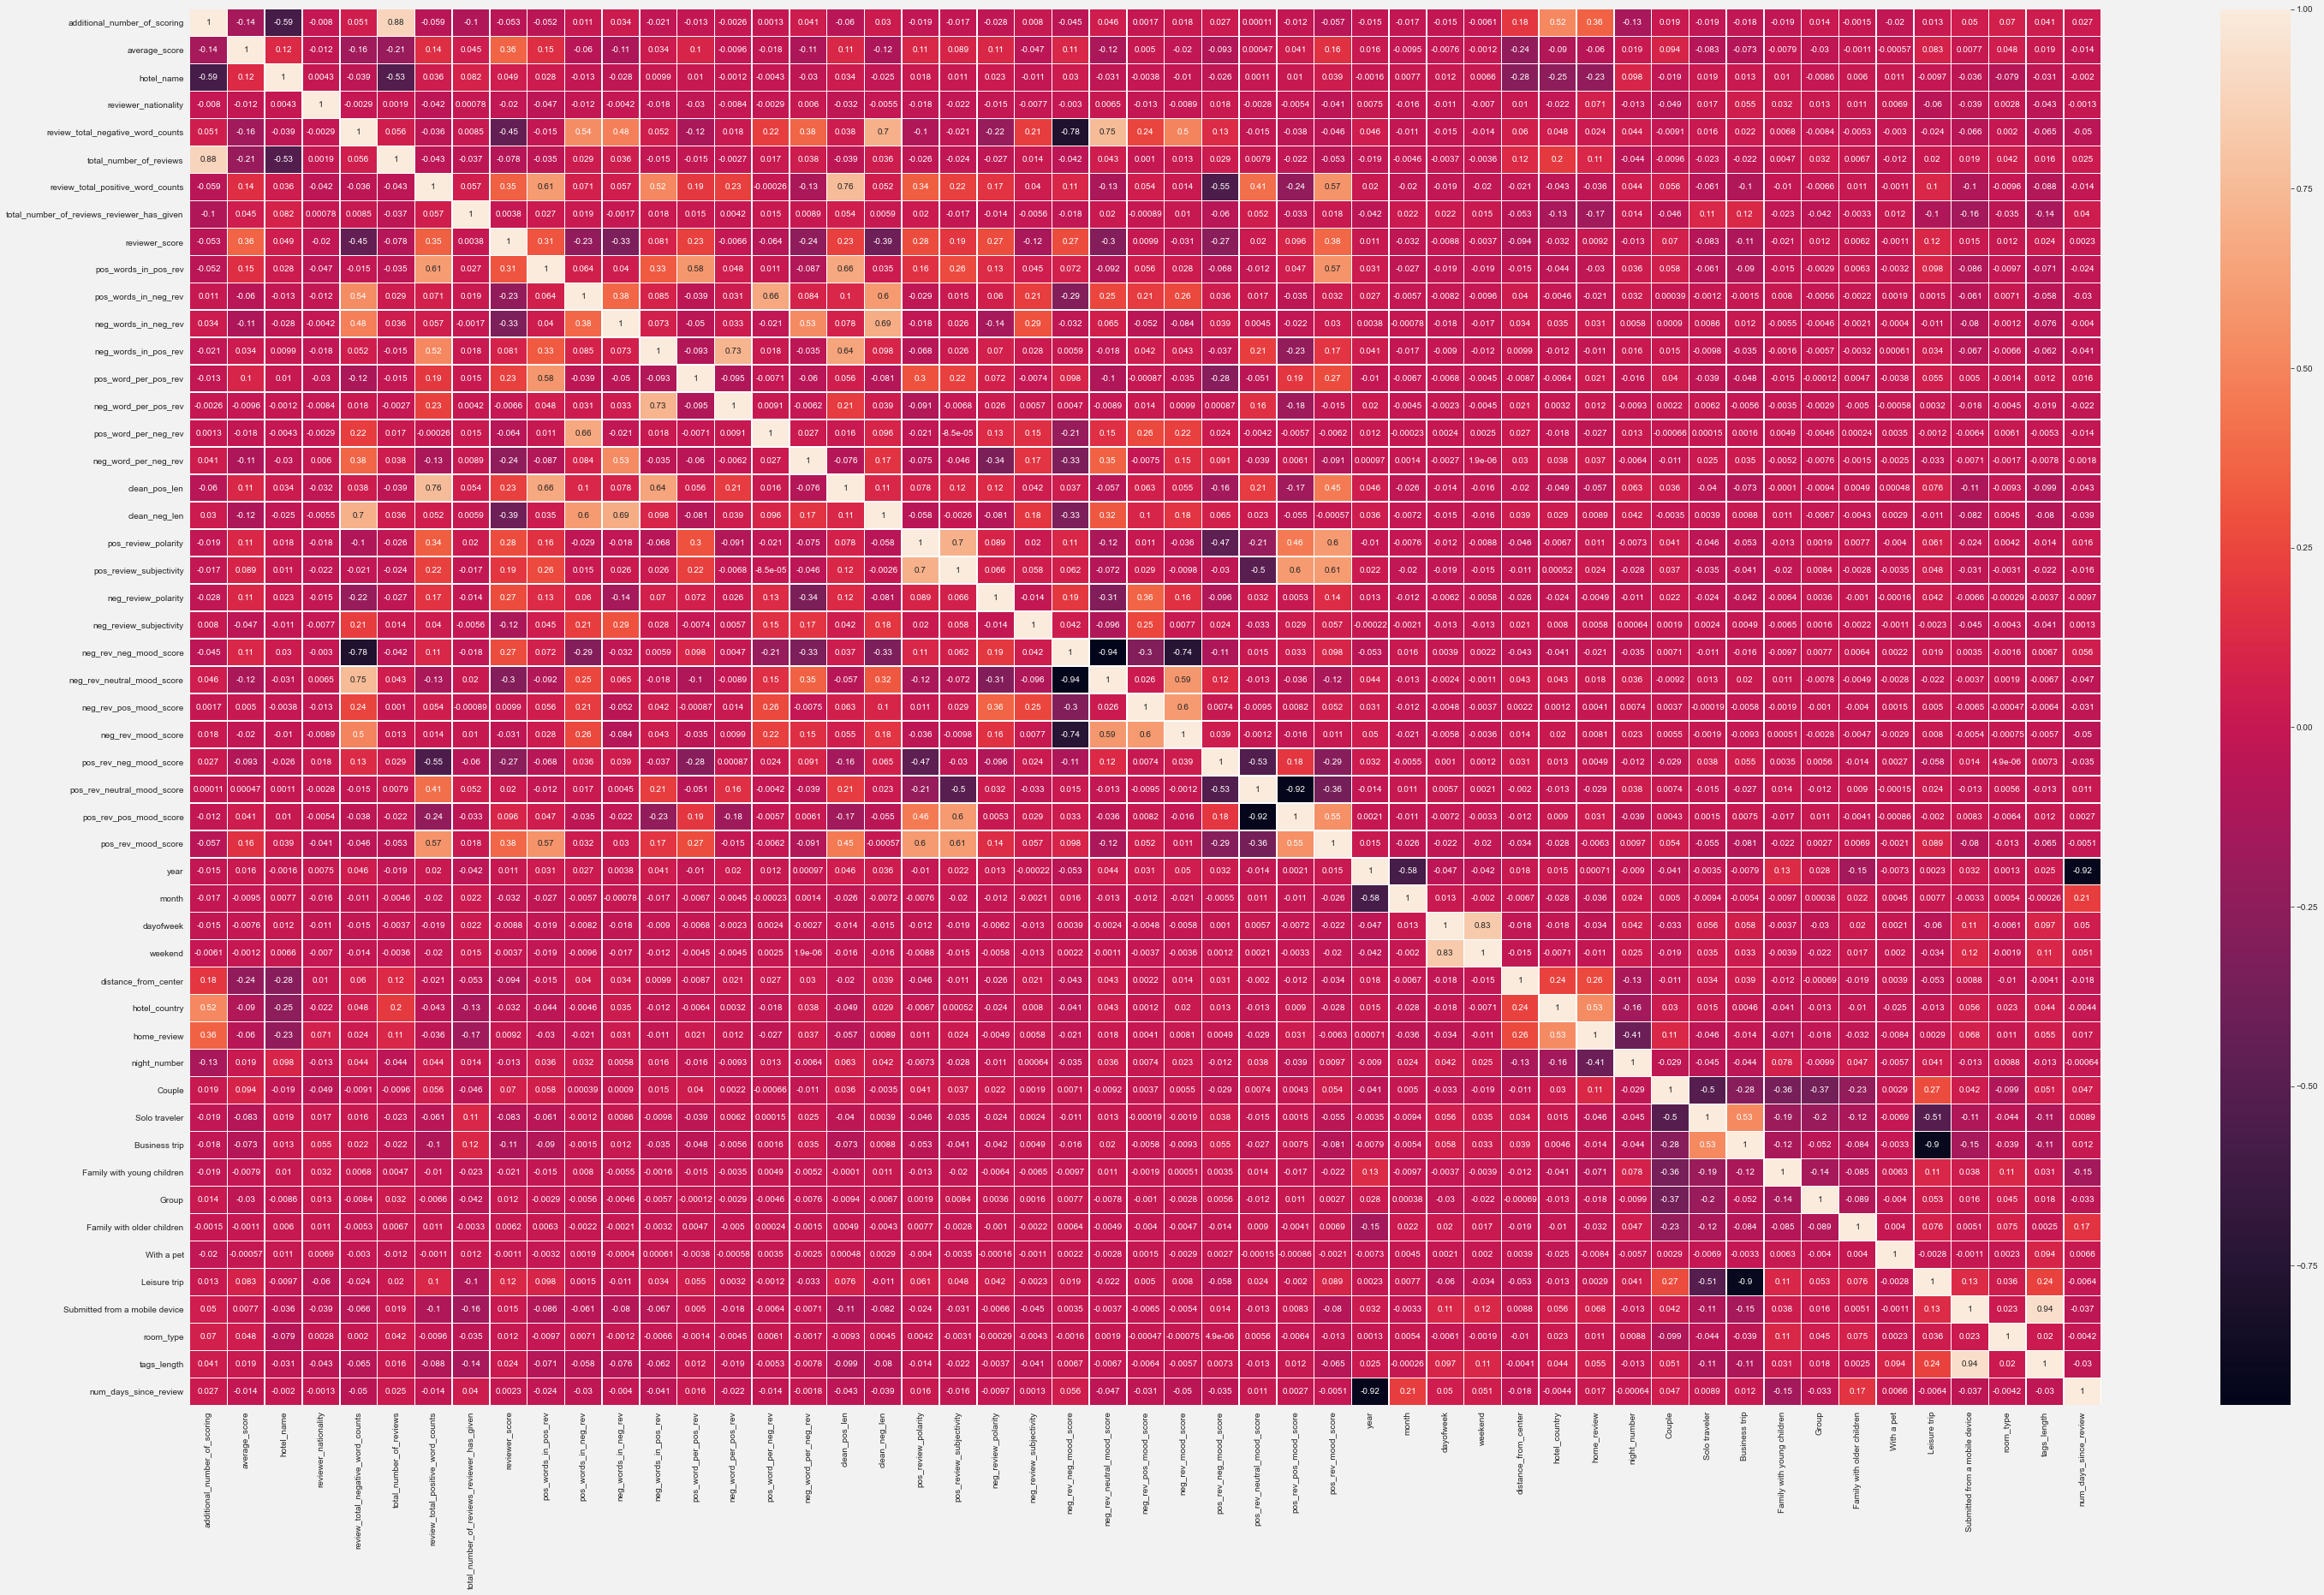

In [55]:
fig, ax = plt.subplots(figsize=(50,30))
sns.heatmap(hotels.corr(), annot=True, linewidths=.5, ax=ax)
pass

In [56]:
# анализ мультиколлинеарности
pivot = hotels.corr()

for col in pivot:
    pivot[col] = pivot[col].apply(lambda x: np.nan if (abs(x) < 0.72 or x == 1) else x)
for col in pivot:
    pivot = pivot.dropna(how='all')
    pivot = pivot.dropna(how='all', axis='columns')

multi_corr_list = []
for lower_bound in np.linspace(0.98, 0.72, num=14):
    for col in pivot.columns:
        if pivot[col].max() > lower_bound or pivot[col].min() < -lower_bound:
            multi_corr_list.append(col)
            
print(set(multi_corr_list))

{'pos_rev_pos_mood_score', 'Business trip', 'num_days_since_review', 'neg_word_per_pos_rev', 'total_number_of_reviews', 'year', 'neg_rev_neutral_mood_score', 'neg_words_in_pos_rev', 'weekend', 'Leisure trip', 'review_total_negative_word_counts', 'review_total_positive_word_counts', 'tags_length', 'neg_rev_mood_score', 'additional_number_of_scoring', 'clean_pos_len', 'Submitted from a mobile device', 'pos_rev_neutral_mood_score', 'neg_rev_neg_mood_score', 'dayofweek'}


In [57]:
#удаление одного из пары скоррелированных признаков
hotels = hotels.drop(['additional_number_of_scoring',
                      'dayofweek',
                      'year',
                      'pos_rev_neutral_mood_score',
                      'neg_rev_neg_mood_score',
                      'neg_word_per_pos_rev',
                      'Submitted from a mobile device',
                      'Leisure trip'
                      ],
                     axis=1)

# Проверка важности признаков

In [58]:
# перед обучением модели явно укажем категориальный тип 
cat_cols = ['hotel_country',
            'hotel_name',
            'month', 
            'night_number', 
            'reviewer_nationality', 
            'room_type', 
            'weekend',
            'home_review',
            'tags_length',
            'Couple',
            'Solo traveler',
            'Business trip',
            'Family with young children',
            'Group',
            'Family with older children',
            'With a pet'
            ]
hotels[cat_cols] = hotels[cat_cols].astype('category')

In [74]:
hotels_selective = hotels.copy()

In [75]:
num_cols = ['review_total_negative_word_counts',
            'review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given', 
            'total_number_of_reviews',
            'average_score',
            'pos_review_polarity',
            'pos_review_subjectivity',
            'neg_review_polarity',
            'neg_review_subjectivity',
            'distance_from_center',
            'num_days_since_review',
            'neg_rev_neutral_mood_score',
            'neg_rev_pos_mood_score',
            'neg_rev_mood_score',
            'pos_rev_neg_mood_score',
            'pos_rev_pos_mood_score',
            'pos_rev_mood_score',
            'pos_words_in_neg_rev',
            'neg_words_in_pos_rev',
            'pos_word_per_pos_rev',
            'pos_word_per_neg_rev',
            'neg_word_per_neg_rev',
            'clean_neg_len',
            'clean_pos_len'
            ]

In [76]:
X = hotels_selective.drop(['reviewer_score'], axis = 1)  
y = hotels_selective['reviewer_score'] 
y=y.astype('int')

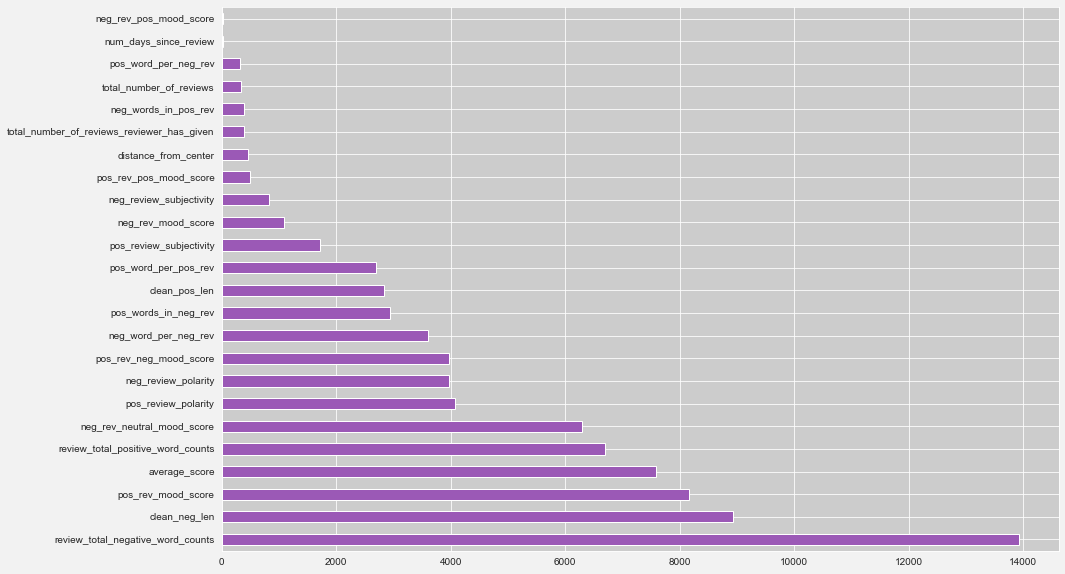

In [77]:
# числовые признаки
plt.rcParams['figure.figsize'] = (15,10)
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True, ascending = False)
imp_num.plot(kind = 'barh')
pass

In [78]:
imp_num

review_total_negative_word_counts             13920.291102
clean_neg_len                                  8931.166040
pos_rev_mood_score                             8153.092548
average_score                                  7588.683414
review_total_positive_word_counts              6690.361842
neg_rev_neutral_mood_score                     6290.415869
pos_review_polarity                            4078.930637
neg_review_polarity                            3962.654739
pos_rev_neg_mood_score                         3960.587105
neg_word_per_neg_rev                           3595.109096
pos_words_in_neg_rev                           2939.655266
clean_pos_len                                  2842.059841
pos_word_per_pos_rev                           2690.148757
pos_review_subjectivity                        1708.834480
neg_rev_mood_score                             1093.367599
neg_review_subjectivity                         825.699878
pos_rev_pos_mood_score                          496.2318

In [79]:
#удаляем два самых слабых
imoprtant_cols = []
del_num = 2
imoprtant_cols.extend(imp_num.head(len(imp_num)-del_num).index)

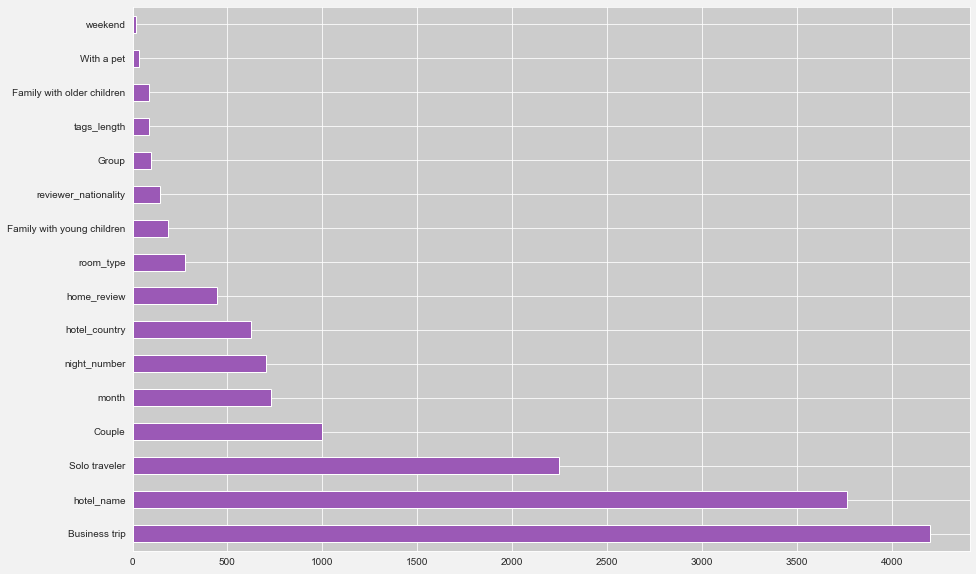

In [80]:
#категориальные признаки
from sklearn.feature_selection import chi2 # хи-квадрат
plt.rcParams['figure.figsize'] = (15,10)
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True, ascending = False)
imp_cat.plot(kind = 'barh')
pass

In [81]:
imp_cat

Business trip                 4198.832597
hotel_name                    3761.472541
Solo traveler                 2245.000098
Couple                         998.844069
month                          731.116137
night_number                   703.113263
hotel_country                  624.843651
home_review                    445.326376
room_type                      277.120731
Family with young children     186.371642
reviewer_nationality           142.168742
Group                           97.835647
tags_length                     85.464232
Family with older children      85.298643
With a pet                      34.352807
weekend                         16.334551
dtype: float64

In [82]:
#удаляем 5 слабых
del_num = 5 
imoprtant_cols.extend(imp_cat.head(len(imp_cat)-del_num).index)
imoprtant_cols.append('reviewer_score')

In [83]:
imoprtant_cols

['review_total_negative_word_counts',
 'clean_neg_len',
 'pos_rev_mood_score',
 'average_score',
 'review_total_positive_word_counts',
 'neg_rev_neutral_mood_score',
 'pos_review_polarity',
 'neg_review_polarity',
 'pos_rev_neg_mood_score',
 'neg_word_per_neg_rev',
 'pos_words_in_neg_rev',
 'clean_pos_len',
 'pos_word_per_pos_rev',
 'pos_review_subjectivity',
 'neg_rev_mood_score',
 'neg_review_subjectivity',
 'pos_rev_pos_mood_score',
 'distance_from_center',
 'total_number_of_reviews_reviewer_has_given',
 'neg_words_in_pos_rev',
 'total_number_of_reviews',
 'pos_word_per_neg_rev',
 'Business trip',
 'hotel_name',
 'Solo traveler',
 'Couple',
 'month',
 'night_number',
 'hotel_country',
 'home_review',
 'room_type',
 'Family with young children',
 'reviewer_nationality',
 'reviewer_score']

In [84]:
hotels = hotels[imoprtant_cols]

In [85]:
hotels.head(3)

,review_total_negative_word_counts,clean_neg_len,pos_rev_mood_score,average_score,review_total_positive_word_counts,neg_rev_neutral_mood_score,pos_review_polarity,neg_review_polarity,pos_rev_neg_mood_score,neg_word_per_neg_rev,pos_words_in_neg_rev,clean_pos_len,pos_word_per_pos_rev,pos_review_subjectivity,neg_rev_mood_score,neg_review_subjectivity,pos_rev_pos_mood_score,distance_from_center,total_number_of_reviews_reviewer_has_given,neg_words_in_pos_rev,total_number_of_reviews,pos_word_per_neg_rev,Business trip,hotel_name,Solo traveler,Couple,month,night_number,hotel_country,home_review,room_type,Family with young children,reviewer_nationality,reviewer_score
0,1.386294,1,0.5859,8.4,1.609438,1.000,0.600000,0.0,0.000,0.333333,0.0,2,0.25,0.900000,0.0000,0.0,0.655,7.015984,1.945910,0.0,7.597898,0.0,0,50,0,1,2,1,5,1,15,0,8,10.0
1,1.386294,2,0.0000,8.3,1.098612,0.244,0.000000,-0.4,0.000,0.333333,0.0,1,0.00,0.000000,-0.4767,0.6,0.000,7.349340,2.639057,0.0,7.215975,0.0,1,50,0,1,1,0,5,1,8,0,8,6.3
2,1.945910,2,0.3400,8.9,0.000000,0.577,-0.113636,0.0,0.379,0.000000,0.0,1,0.00,0.545455,-0.2960,0.0,0.621,7.351081,2.639057,0.0,6.006353,0.0,0,50,1,0,10,2,1,0,15,0,10,7.5


# Обучение модели

In [86]:
# Теперь выделим тестовую часть
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [87]:
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [88]:
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [89]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.2s finished


In [90]:
#метрики
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAE: 0.8536470418591753
MAPE: 0.12186933207658353


<AxesSubplot:>

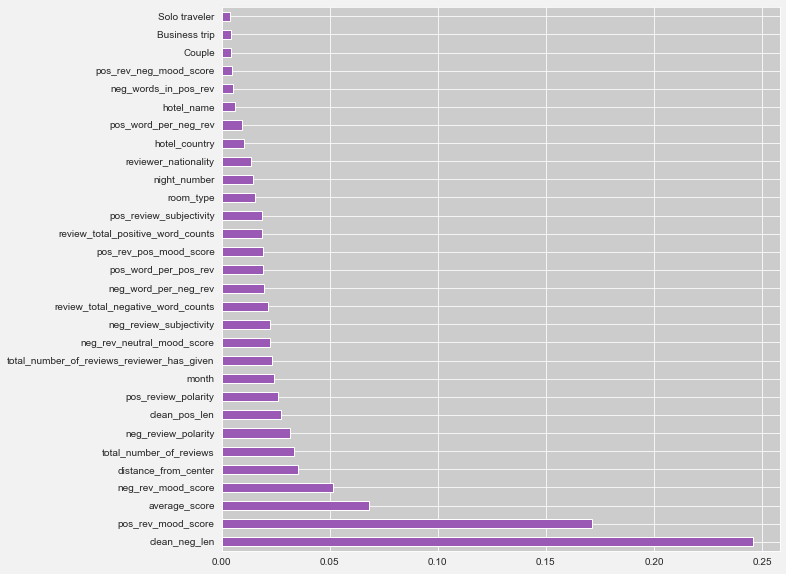

In [91]:
# выводим самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')

In [92]:
improv_percent = 14.138289880751229 - metrics.mean_absolute_percentage_error(y_test, y_pred)*100
print('Результат удалось улучшить на', round(improv_percent,3), '%' )

Результат удалось улучшить на 1.951 %


In [93]:
display(HTML("""<a href="https://www.kaggle.com/abalakinigor">Аккаунт на kaggle"""))